# Convolutional neural network for 1 second samples

## Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
import librosa.display
import tensorflow.keras as keras
import json
from sklearn.utils import shuffle
from itertools import product

from google.colab import drive
import glob

## Reading data

### Mounting Google Drive

In [2]:
# Mounting drive
drive.mount('/content/drive')
# Viewing the data in the folder present from the drive
!ls "/content/drive/My Drive/motor_noise_classifier/preprocessed_data"

Mounted at /content/drive
melSpec_data_1sec.json		    segments1sec_overlap_newLabels.xlsx
melSpec_data_2sec.json		    segments25sec.csv
melSpec_data_5sec.json		    segments2sec.csv
segments1sec.csv		    segments2sec_overlap.csv
segments1sec_overlap.csv	    segments5sec.csv
segments1sec_overlap_newLabels.csv  segments5sec_overlap.csv


### Reading data from Google Drive

In [3]:
# copying audio data from Google drive
!mkdir preprocessed_data
!cd preprocessed_data
!cp -r '/content/drive/My Drive/motor_noise_classifier/preprocessed_data/melSpec_data_1sec.json' preprocessed_data/melSpec_data.json 
!cp -r '/content/drive/My Drive/motor_noise_classifier/preprocessed_data/segments1sec_overlap_newLabels.csv' preprocessed_data/segments1sec.csv
!cd .. 

# importing custom functions
!cp -r '/content/drive/My Drive/motor_noise_classifier/my_functions.py' my_functions.py
from my_functions import *

In [4]:
sample_length = 1

# 1 sec samples 
df_src = pd.read_csv("./preprocessed_data/segments1sec.csv", index_col=0)
mel_spec_metadata_file = 'melSpec_data.json'


with open(f'./preprocessed_data/{mel_spec_metadata_file}') as json_file:
    melSpec_data = json.load(json_file)

melSpec_data.keys()

dict_keys(['melSpecShape0', 'melSpecShape1', 'n_fft', 'hop_length'])

## Data preparation

### Forming melspectrograms from flat arrays

In [5]:
melSpec_shape = (melSpec_data['melSpecShape0'], melSpec_data['melSpecShape1'])

df = reshapeMelSpecs(df_src, melSpec_shape)
df.sample(5)

(4531, 140, 44)


,motorId,isGood,melSpec
46,1,True,"[[-11.348068610213714, -10.28897444267866, -10..."
4311,22,True,"[[-9.662181520350885, -5.494040551298173, -7.3..."
721,4,True,"[[-8.354784095109228, -7.096619000720157, -7.7..."
2351,12,True,"[[-21.45998141155309, -16.748026746545648, -16..."
3217,17,False,"[[-0.3412950639339129, 0.0, -1.201013284033617..."


## Train-Test Split

The dataset will be split with respect to the motor IDs  
- Test set $\sim 20\%$ - 5 motors
- Train/Validation set $\sim 20\%$  - 18 motors

In [6]:
# load presaved custom shuffled train test split motor list
!cp -r '/content/drive/My Drive/motor_noise_classifier/train_test_shuffled_list.csv' train_test_shuffled_list.csv 
custom_shuffled_list = np.loadtxt('./train_test_shuffled_list.csv')
custom_shuffled_list

array([ 6., 18., 13.,  1.,  8.,  7.,  2., 10., 17., 19., 23., 16., 14.,
        3., 20., 22., 15.,  4., 12., 11., 21.,  9.,  5.])

In [7]:
df_train, df_test, shuffled_list_of_motors = splitTrainTestByMotorId(df, 
                                                                     nb_of_test_motors=10, 
                                                                     custom_shuffled_list=custom_shuffled_list,
                                                                     threshold=0.55,
                                                                     print_results=True
                                                                     )

shuffled_list_of_motors [ 6. 18. 13.  1.  8.  7.  2. 10. 17. 19. 23. 16. 14.  3. 20. 22. 15.  4.
 12. 11. 21.  9.  5.]
trainSet [23. 16. 14.  3. 20. 22. 15.  4. 12. 11. 21.  9.  5.]
testSet [ 6. 18. 13.  1.  8.  7.  2. 10. 17. 19.]


In [27]:
# Save the train/test list split for further use
np.savetxt('/content/drive/My Drive/motor_noise_classifier/train_test_shuffled_list.csv', shuffled_list_of_motors, delimiter=',')

## Normalisation with respect to trainset minimum/maximum

In [8]:
## Change to minMaxScaler

train_minimum = np.array(list(df_train.melSpec)).min()
train_maximum = np.array(list(df_train.melSpec)).max()

df_train.melSpec = normalise_dataset(df_train.melSpec, train_minimum, train_maximum)
df_test.melSpec = normalise_dataset(df_test.melSpec, train_minimum, train_maximum)

In [ ]:
df_train

,motorId,isGood,melSpec
0,1,True,"[[0.8037009280020257, 0.7987064589514401, 0.73..."
1,1,True,"[[0.8082208866169677, 0.8241121499830566, 0.83..."
2,1,True,"[[0.8362988690836369, 0.8359147877714878, 0.81..."
3,1,True,"[[0.7931875361176519, 0.8102894444013629, 0.77..."
4,1,True,"[[0.7129062323557981, 0.737094645698341, 0.727..."
...,...,...,...
4526,23,False,"[[0.9946696106387369, 1.0, 0.9875084788793369,..."
4527,23,False,"[[0.9944387533908158, 1.0, 0.985900631844029, ..."
4528,23,False,"[[0.9935712020929512, 1.0, 0.9864533497866294,..."
4529,23,False,"[[0.9959703189928698, 1.0, 0.9872190040087113,..."


## Building a CNN model

### Test model

In [ ]:
input_submodel = buildCNNInputSubmodel(melSpec_shape)
middle_submodel = buildCNNMiddleSubmodel(nb_of_conv_layers=4,
                                         filter_numbers=[16, 32, 64, 128],
                                         kernel_sizes=[3 for i in range(4)],
                                         activations=['selu' for i in range(4)]
                                         )
output_submodel = Dense(1, activation='sigmoid', name='output')

model = buildModel([input_submodel, middle_submodel, output_submodel],
                   loss='binary_crossentropy',
                   optimizer='adam',
                   metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_submodel (Sequential)  (None, 140, 44, 1)       0         
                                                                 
 middle_submodel (Sequential  (None, 2048)             97152     
 )                                                               
                                                                 
 output (Dense)              (None, 1)                 2049      
                                                                 
Total params: 99,201
Trainable params: 99,201
Non-trainable params: 0
_________________________________________________________________


In [ ]:
callbacks = [
             keras.callbacks.EarlyStopping(
                 monitor="val_loss", 
                 patience=2,
                 verbose=0)
             ]

score, epoch_number = KfoldValidationCNNTraining(model,
                                                 df_train,
                                                 k_folds=4,
                                                 epochs=10,
                                                 callbacks=callbacks,
                                                 )

fold: #1
fold: #2
fold: #3
fold: #4
accuracies: [0.9390863180160522, 1.0, 1.0, 1.0], mean: 0.9847715795040131
epochs: [3, 3, 3, 3], mean: 3.0


In [ ]:
score

0.9847715795040131

In [ ]:
epoch_number

3

## Grid Search

params:
- CNN archi
- activations
- batch size

In [9]:
callbacks = [keras.callbacks.EarlyStopping(
                 monitor="val_loss", 
                 patience=2,
                 verbose=0)
             ]

### Check activations 

In [ ]:
filter_numbers = [ 
                  [16, 32], 
                #   [128,256],
                  [64, 128, 256]
                  ]
activations = ['relu', 'selu']
batch_sizes = [64] 

params = pd.DataFrame(list(product(filter_numbers, activations, batch_sizes)), 
             columns=['filter_numbers', 'activation', 'batch_size'])
params

,filter_numbers,activation,batch_size
0,"[16, 32]",relu,64
1,"[16, 32]",selu,64
2,"[64, 128, 256]",relu,64
3,"[64, 128, 256]",selu,64


In [ ]:
grid_search_results = GridSearchCNN(params,
                                    df_train,
                                    k_folds=4,
                                    epochs=20,
                                    callbacks=callbacks,
                                    input_shape=melSpec_shape)

#1/4
fold: #1
fold: #2
fold: #3
fold: #4
accuracies: [0.5719119906425476, 1.0, 1.0, 1.0], mean: 0.8929779976606369
epochs: [6, 6, 5, 5], mean: 5.5
#2/4
fold: #1
fold: #2
fold: #3
fold: #4
accuracies: [0.663282573223114, 1.0, 1.0, 1.0], mean: 0.9158206433057785
epochs: [5, 5, 5, 5], mean: 5.0
#3/4
fold: #1
fold: #2
fold: #3
fold: #4
accuracies: [0.529610812664032, 1.0, 1.0, 1.0], mean: 0.882402703166008
epochs: [3, 3, 3, 3], mean: 3.0
#4/4
fold: #1
fold: #2
fold: #3
fold: #4
accuracies: [0.5600676536560059, 0.9983079433441162, 1.0, 1.0], mean: 0.8895938992500305
epochs: [4, 3, 3, 3], mean: 3.25


In [ ]:
grid_search_results

,nb_of_layers,filter_numbers,activation,batch_size,epochs_nb,accuracy
0,2,"[16, 32]",relu,64,6,0.892978
1,2,"[16, 32]",selu,64,5,0.915821
2,3,"[64, 128, 256]",relu,64,3,0.882403
3,3,"[64, 128, 256]",selu,64,4,0.889594


<Figure size 432x288 with 0 Axes>

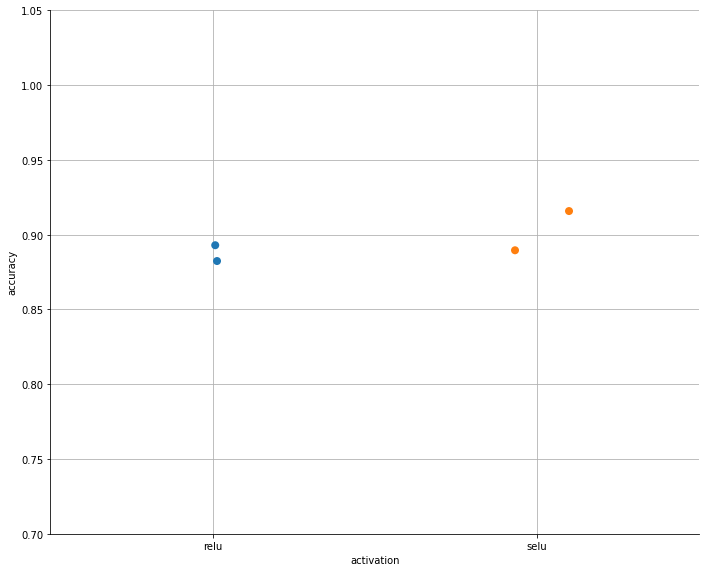

In [ ]:
formGridSearchCatplot(grid_search_results, parameter_to_visualise='activation')

Activation function SeLu brought slightly better results

### Check batch sizes

In [10]:
filter_numbers = [ 
                  [16, 32], 
                #   [128,256],
                  [64, 128, 256]
                  ]
activations = ['selu']
batch_sizes = [16, 32, 64, 128, 256] 

params = pd.DataFrame(list(product(filter_numbers, activations, batch_sizes)), 
             columns=['filter_numbers', 'activation', 'batch_size'])
params

,filter_numbers,activation,batch_size
0,"[16, 32]",selu,16
1,"[16, 32]",selu,32
2,"[16, 32]",selu,64
3,"[16, 32]",selu,128
4,"[16, 32]",selu,256
5,"[64, 128, 256]",selu,16
6,"[64, 128, 256]",selu,32
7,"[64, 128, 256]",selu,64
8,"[64, 128, 256]",selu,128
9,"[64, 128, 256]",selu,256


In [11]:
grid_search_results = GridSearchCNN(params,
                                    df_train,
                                    k_folds=4,
                                    epochs=20,
                                    callbacks=callbacks,
                                    input_shape=melSpec_shape)

#1/10
fold: #1
fold: #2
fold: #3
fold: #4
accuracies: [0.4551607370376587, 1.0, 1.0, 1.0], mean: 0.8637901842594147
epochs: [3, 3, 3, 3], mean: 3.0
#2/10
fold: #1
fold: #2
fold: #3
fold: #4
accuracies: [0.4771573543548584, 1.0, 1.0, 1.0], mean: 0.8692893385887146
epochs: [3, 3, 3, 3], mean: 3.0
#3/10
fold: #1
fold: #2
fold: #3
fold: #4
accuracies: [0.3333333432674408, 1.0, 1.0, 1.0], mean: 0.8333333358168602
epochs: [3, 3, 3, 3], mean: 3.0
#4/10
fold: #1
fold: #2
fold: #3
fold: #4
accuracies: [0.3333333432674408, 0.8781725764274597, 1.0, 1.0], mean: 0.8028764799237251
epochs: [3, 3, 3, 3], mean: 3.0
#5/10
fold: #1
fold: #2
fold: #3
fold: #4
accuracies: [0.3333333432674408, 0.6717427968978882, 1.0, 1.0], mean: 0.7512690350413322
epochs: [4, 4, 4, 4], mean: 4.0
#6/10
fold: #1
fold: #2
fold: #3
fold: #4
accuracies: [0.673434853553772, 1.0, 1.0, 1.0], mean: 0.918358713388443
epochs: [3, 3, 3, 3], mean: 3.0
#7/10
fold: #1
fold: #2
fold: #3
fold: #4
accuracies: [0.6023688912391663, 1.0, 1.0,

In [14]:
grid_search_results

,nb_of_layers,filter_numbers,activation,batch_size,epochs_nb,accuracy
0,2,"[16, 32]",selu,16,3,0.863790
1,2,"[16, 32]",selu,32,3,0.869289
2,2,"[16, 32]",selu,64,3,0.833333
3,2,"[16, 32]",selu,128,3,0.802876
4,2,"[16, 32]",selu,256,4,0.751269
5,3,"[64, 128, 256]",selu,16,3,0.918359
6,3,"[64, 128, 256]",selu,32,3,0.900592
7,3,"[64, 128, 256]",selu,64,3,0.834179
8,3,"[64, 128, 256]",selu,128,3,0.833333
9,3,"[64, 128, 256]",selu,256,3,0.750846


<Figure size 432x288 with 0 Axes>

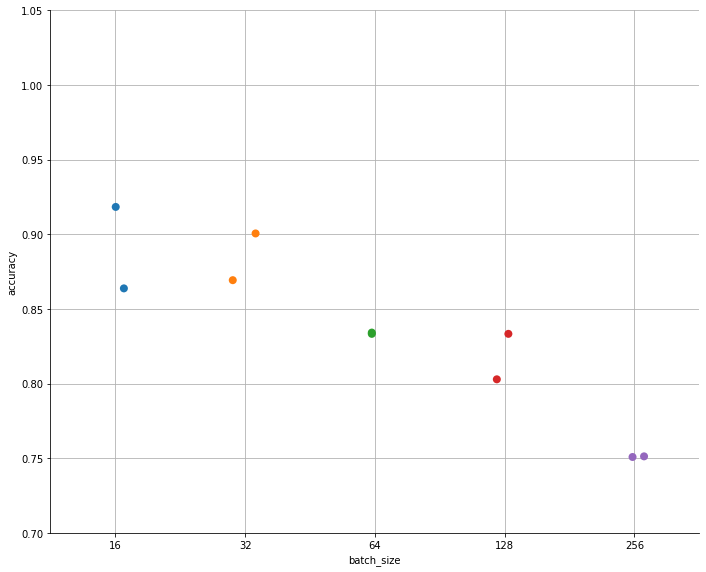

In [15]:
formGridSearchCatplot(grid_search_results, parameter_to_visualise='batch_size')

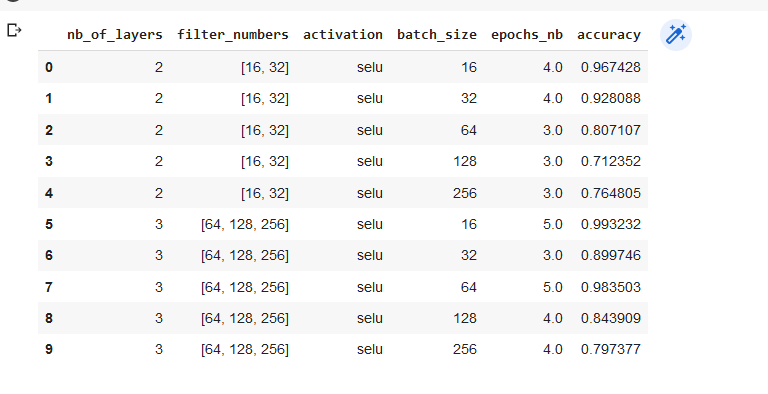

### Check different CNN layers parameters

In [9]:
filter_numbers = [ 
                  [16, 32], 
                  [32, 64],
                  [64,128],
                  [128,256],
                  [16, 32, 64],
                  [32, 64, 128],
                  [64, 128, 256],
                  ]
activations = ['relu']
batch_sizes = [16] 

params = pd.DataFrame(list(product(filter_numbers, activations, batch_sizes)), 
             columns=['filter_numbers', 'activation', 'batch_size'])
params

,filter_numbers,activation,batch_size
0,"[16, 32]",relu,16
1,"[32, 64]",relu,16
2,"[64, 128]",relu,16
3,"[128, 256]",relu,16
4,"[16, 32, 64]",relu,16
5,"[32, 64, 128]",relu,16
6,"[64, 128, 256]",relu,16


In [29]:
grid_search_results = GridSearchCNN(params,
                                    df_train,
                                    k_folds=4,
                                    epochs=20,
                                    callbacks=callbacks,
                                    input_shape=melSpec_shape)

#1/7
fold: #1
fold: #2
fold: #3
fold: #4
accuracies: [0.7868020534515381, 1.0, 1.0, 1.0], mean: 0.9467005133628845
epochs: [3, 3, 3, 3], mean: 3.0
#2/7
fold: #1
fold: #2
fold: #3
fold: #4
accuracies: [0.8392555117607117, 0.9695431590080261, 1.0, 1.0], mean: 0.9521996676921844
epochs: [4, 3, 3, 3], mean: 3.25
#3/7
fold: #1
fold: #2
fold: #3
fold: #4
accuracies: [0.6192893385887146, 0.9441624283790588, 0.9576988220214844, 1.0], mean: 0.8802876472473145
epochs: [3, 3, 3, 3], mean: 3.0
#4/7
fold: #1
fold: #2
fold: #3
fold: #4
accuracies: [0.7478849291801453, 0.8798646330833435, 0.9678511023521423, 1.0], mean: 0.8989001661539078
epochs: [3, 3, 3, 3], mean: 3.0
#5/7
fold: #1
fold: #2
fold: #3
fold: #4
accuracies: [0.7783417701721191, 0.9746192693710327, 0.9712352156639099, 1.0], mean: 0.9310490638017654
epochs: [3, 3, 3, 3], mean: 3.0
#6/7
fold: #1
fold: #2
fold: #3
fold: #4
accuracies: [0.7631133794784546, 0.8121827244758606, 0.6835871338844299, 1.0], mean: 0.8147208094596863
epochs: [4, 3,

In [30]:
grid_search_results

,nb_of_layers,filter_numbers,activation,batch_size,epochs_nb,accuracy
0,2,"[16, 32]",relu,16,3,0.946701
1,2,"[32, 64]",relu,16,4,0.952200
2,2,"[64, 128]",relu,16,3,0.880288
3,2,"[128, 256]",relu,16,3,0.898900
4,3,"[16, 32, 64]",relu,16,3,0.931049
5,3,"[32, 64, 128]",relu,16,4,0.814721
6,3,"[64, 128, 256]",relu,16,4,0.820220


In [10]:
grid_search_results["filter_numbers_str"] = grid_search_results["filter_numbers"]
grid_search_results = grid_search_results.astype({"filter_numbers_str": str})

grid_search_results

,filter_numbers,activation,batch_size,epochs_nb,accuracy,filter_numbers_str
0,"[16, 32]",relu,16,3,0.946701,"[16, 32]"
1,"[32, 64]",relu,16,4,0.952200,"[32, 64]"
2,"[64, 128]",relu,16,3,0.880288,"[64, 128]"
3,"[128, 256]",relu,16,3,0.898900,"[128, 256]"
4,"[16, 32, 64]",relu,16,3,0.931049,"[16, 32, 64]"
5,"[32, 64, 128]",relu,16,4,0.814721,"[32, 64, 128]"
6,"[64, 128, 256]",relu,16,4,0.820220,"[64, 128, 256]"


<Figure size 432x288 with 0 Axes>

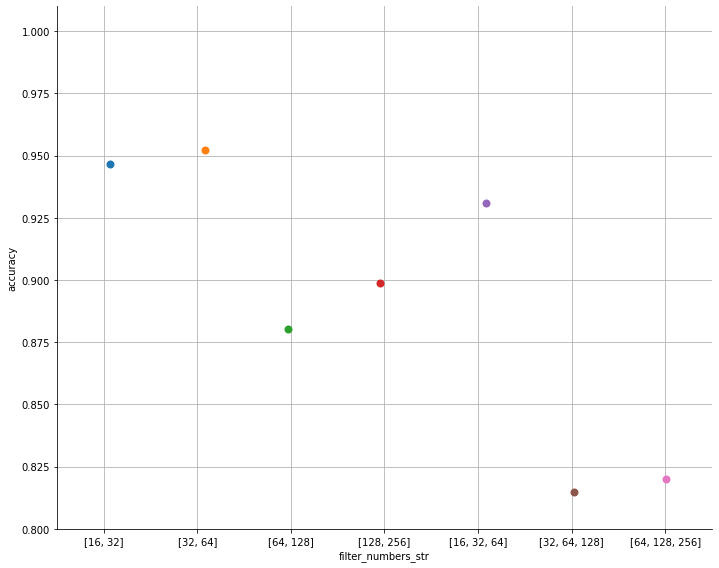

In [13]:
formGridSearchCatplot(grid_search_results, parameter_to_visualise='filter_numbers_str', ylim=[0.8, 1.01])

The simplest, 2 hidden layers networks, with lower filter numbers performed the best

## Final CNN model





In [14]:
samples_good_count = df.isGood.loc[df.isGood==True].count()
samples_bad_count = df.isGood.loc[df.isGood==False].count()

baseline = np.max([samples_good_count, samples_bad_count]) / (samples_good_count + samples_bad_count)
print(f"baseline to beat: {baseline*100 :.2f}%")

baseline to beat: 56.52%


The best parameters found in grid search:
- activation: ReLu
- batch size: 16
- hidden layers structure: [16, 32]

In [25]:
input_submodel = buildCNNInputSubmodel(melSpec_shape)
middle_submodel = buildCNNMiddleSubmodel(nb_of_conv_layers=2,
                                         filter_numbers=[32, 64],
                                         kernel_sizes=[3 for i in range(2)],
                                         activations=['selu' for i in range(2)]
                                         )
output_submodel = Dense(1, activation='sigmoid', name='output')

cnn_clf = buildModel([input_submodel, middle_submodel, output_submodel],
                   loss='binary_crossentropy',
                   optimizer='adam',
                   metrics=['accuracy'])

cnn_clf.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_submodel (Sequential)  (None, 140, 44, 1)       0         
                                                                 
 middle_submodel (Sequential  (None, 24640)            18816     
 )                                                               
                                                                 
 output (Dense)              (None, 1)                 24641     
                                                                 
Total params: 43,457
Trainable params: 43,457
Non-trainable params: 0
_________________________________________________________________


In [26]:
callbacks = [keras.callbacks.EarlyStopping(monitor="val_loss", 
                                           patience=2, 
                                           verbose=0)
            ]

In [27]:
model_accuracy, epochs_nb = KfoldValidationCNNTraining(cnn_clf,
                                                       df_train,
                                                       k_folds=3,
                                                       epochs=20,
                                                       batch_size=16,
                                                       callbacks=callbacks
                                                       )


fold: #1
fold: #2
fold: #3
accuracies: [0.5126903653144836, 0.932741105556488, 1.0], mean: 0.8151438236236572
epochs: [5, 5, 5], mean: 5.0


### Training on a full training dataset

In [28]:
X_train, y_train = convertDatasetToArrays(df_train) 

In [29]:
history = cnn_clf.fit(X_train, 
                      y_train, 
                      epochs=int(epochs_nb) - 2,
                      batch_size=16,
                      )

Epoch 1/3
161/161 [==============================] - 25s 153ms/step - loss: 4.4403e-04 - accuracy: 1.0000
Epoch 2/3
161/161 [==============================] - 25s 154ms/step - loss: 3.4524e-04 - accuracy: 1.0000
Epoch 3/3
161/161 [==============================] - 25s 153ms/step - loss: 2.7501e-04 - accuracy: 1.0000


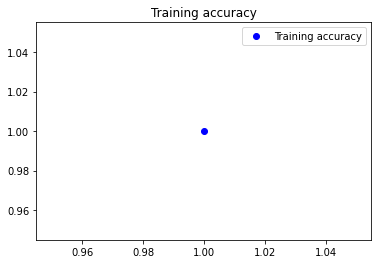

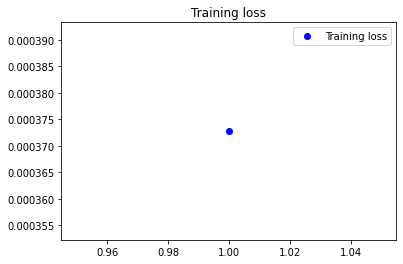

In [ ]:
import matplotlib.pyplot as plt
accuracy = history.history["accuracy"]
# val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
# val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
# plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
# plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training loss")
plt.legend()
plt.show()

### Test set evaluation

In [34]:
X_test, y_test, motorIds_test = convertDatasetToArrays(df_test, return_motorIds_array=True)

cnn_clf.evaluate(X_test, y_test)

62/62 [==============================] - 5s 79ms/step - loss: 0.1430 - accuracy: 0.9437


[0.14295515418052673, 0.9436548352241516]

In [35]:
preds_test = cnn_clf.predict(X_test)

preds_test_round = []
for pred in preds_test:
    pred_round = 1 if pred >= 0.5 else 0
    preds_test_round.append(pred_round)

In [36]:
results_table = countPredictionsByMotorId(y_test, preds_test_round, motorIds_test)
results_table.style.format({'good': '{:,.0f}',
                            'bad': '{:,.0f}',  
                            'prediction_confidence': '{:,.2%}'.format})

,good,bad,ground_truth,summed_prediction,prediction_confidence
motorId,,,,,
1,197,0,True,True,100.00%
2,197,0,True,True,100.00%
6,197,0,True,True,100.00%
7,197,0,True,True,100.00%
8,197,0,True,True,100.00%
10,194,3,True,True,98.48%
13,3,194,False,False,98.48%
17,0,197,False,False,100.00%
18,0,197,False,False,100.00%


In [37]:
final_accuracy = (results_table.ground_truth == results_table.summed_prediction).astype(int).sum() / len(results_table.ground_truth)
print(f"final accuracy: {final_accuracy*100 :.2f}%")

final accuracy: 90.00%
